# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


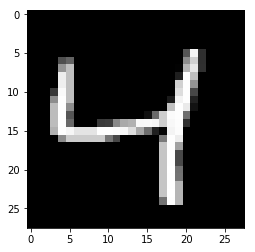

In [4]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [7]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name = "inputs")
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name = "targets")

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding = "same")
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding = "same")
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding = "same")
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14, 14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28, 28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3, 3), padding = "same", activation = None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name = "decoded")

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = targets_, logits = logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [8]:
sess = tf.Session()

In [9]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7251
Epoch: 1/20... Training loss: 0.7122
Epoch: 1/20... Training loss: 0.7026
Epoch: 1/20... Training loss: 0.6951
Epoch: 1/20... Training loss: 0.6893
Epoch: 1/20... Training loss: 0.6847
Epoch: 1/20... Training loss: 0.6804
Epoch: 1/20... Training loss: 0.6762
Epoch: 1/20... Training loss: 0.6718
Epoch: 1/20... Training loss: 0.6675
Epoch: 1/20... Training loss: 0.6623
Epoch: 1/20... Training loss: 0.6560
Epoch: 1/20... Training loss: 0.6497
Epoch: 1/20... Training loss: 0.6420
Epoch: 1/20... Training loss: 0.6322
Epoch: 1/20... Training loss: 0.6220
Epoch: 1/20... Training loss: 0.6096
Epoch: 1/20... Training loss: 0.5954
Epoch: 1/20... Training loss: 0.5785
Epoch: 1/20... Training loss: 0.5610
Epoch: 1/20... Training loss: 0.5474
Epoch: 1/20... Training loss: 0.5284
Epoch: 1/20... Training loss: 0.5170
Epoch: 1/20... Training loss: 0.5096
Epoch: 1/20... Training loss: 0.5093
Epoch: 1/20... Training loss: 0.5318
Epoch: 1/20... Training loss: 0.5102
E

Epoch: 1/20... Training loss: 0.1632
Epoch: 1/20... Training loss: 0.1677
Epoch: 1/20... Training loss: 0.1619
Epoch: 1/20... Training loss: 0.1686
Epoch: 1/20... Training loss: 0.1652
Epoch: 1/20... Training loss: 0.1634
Epoch: 1/20... Training loss: 0.1609
Epoch: 1/20... Training loss: 0.1600
Epoch: 1/20... Training loss: 0.1622
Epoch: 1/20... Training loss: 0.1666
Epoch: 1/20... Training loss: 0.1591
Epoch: 1/20... Training loss: 0.1666
Epoch: 1/20... Training loss: 0.1658
Epoch: 1/20... Training loss: 0.1614
Epoch: 1/20... Training loss: 0.1623
Epoch: 1/20... Training loss: 0.1638
Epoch: 1/20... Training loss: 0.1663
Epoch: 1/20... Training loss: 0.1654
Epoch: 1/20... Training loss: 0.1621
Epoch: 1/20... Training loss: 0.1668
Epoch: 1/20... Training loss: 0.1620
Epoch: 1/20... Training loss: 0.1582
Epoch: 1/20... Training loss: 0.1696
Epoch: 1/20... Training loss: 0.1603
Epoch: 1/20... Training loss: 0.1596
Epoch: 1/20... Training loss: 0.1552
Epoch: 1/20... Training loss: 0.1600
E

Epoch: 2/20... Training loss: 0.1354
Epoch: 2/20... Training loss: 0.1368
Epoch: 2/20... Training loss: 0.1377
Epoch: 2/20... Training loss: 0.1398
Epoch: 2/20... Training loss: 0.1380
Epoch: 2/20... Training loss: 0.1454
Epoch: 2/20... Training loss: 0.1342
Epoch: 2/20... Training loss: 0.1333
Epoch: 2/20... Training loss: 0.1373
Epoch: 2/20... Training loss: 0.1337
Epoch: 2/20... Training loss: 0.1369
Epoch: 2/20... Training loss: 0.1331
Epoch: 2/20... Training loss: 0.1363
Epoch: 2/20... Training loss: 0.1344
Epoch: 2/20... Training loss: 0.1354
Epoch: 2/20... Training loss: 0.1411
Epoch: 2/20... Training loss: 0.1375
Epoch: 2/20... Training loss: 0.1352
Epoch: 2/20... Training loss: 0.1324
Epoch: 2/20... Training loss: 0.1423
Epoch: 2/20... Training loss: 0.1342
Epoch: 2/20... Training loss: 0.1370
Epoch: 2/20... Training loss: 0.1340
Epoch: 2/20... Training loss: 0.1373
Epoch: 2/20... Training loss: 0.1381
Epoch: 2/20... Training loss: 0.1377
Epoch: 2/20... Training loss: 0.1330
E

Epoch: 3/20... Training loss: 0.1268
Epoch: 3/20... Training loss: 0.1252
Epoch: 3/20... Training loss: 0.1324
Epoch: 3/20... Training loss: 0.1258
Epoch: 3/20... Training loss: 0.1211
Epoch: 3/20... Training loss: 0.1254
Epoch: 3/20... Training loss: 0.1222
Epoch: 3/20... Training loss: 0.1305
Epoch: 3/20... Training loss: 0.1224
Epoch: 3/20... Training loss: 0.1260
Epoch: 3/20... Training loss: 0.1294
Epoch: 3/20... Training loss: 0.1289
Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1287
Epoch: 3/20... Training loss: 0.1240
Epoch: 3/20... Training loss: 0.1277
Epoch: 3/20... Training loss: 0.1226
Epoch: 3/20... Training loss: 0.1290
Epoch: 3/20... Training loss: 0.1307
Epoch: 3/20... Training loss: 0.1281
Epoch: 3/20... Training loss: 0.1296
Epoch: 3/20... Training loss: 0.1262
Epoch: 3/20... Training loss: 0.1250
Epoch: 3/20... Training loss: 0.1238
Epoch: 3/20... Training loss: 0.1254
Epoch: 3/20... Training loss: 0.1257
Epoch: 3/20... Training loss: 0.1288
E

Epoch: 3/20... Training loss: 0.1229
Epoch: 3/20... Training loss: 0.1237
Epoch: 3/20... Training loss: 0.1198
Epoch: 3/20... Training loss: 0.1215
Epoch: 3/20... Training loss: 0.1243
Epoch: 3/20... Training loss: 0.1232
Epoch: 3/20... Training loss: 0.1218
Epoch: 3/20... Training loss: 0.1192
Epoch: 3/20... Training loss: 0.1203
Epoch: 3/20... Training loss: 0.1262
Epoch: 3/20... Training loss: 0.1246
Epoch: 3/20... Training loss: 0.1248
Epoch: 4/20... Training loss: 0.1172
Epoch: 4/20... Training loss: 0.1207
Epoch: 4/20... Training loss: 0.1217
Epoch: 4/20... Training loss: 0.1225
Epoch: 4/20... Training loss: 0.1246
Epoch: 4/20... Training loss: 0.1202
Epoch: 4/20... Training loss: 0.1206
Epoch: 4/20... Training loss: 0.1230
Epoch: 4/20... Training loss: 0.1250
Epoch: 4/20... Training loss: 0.1158
Epoch: 4/20... Training loss: 0.1183
Epoch: 4/20... Training loss: 0.1196
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1253
Epoch: 4/20... Training loss: 0.1210
E

Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1156
Epoch: 4/20... Training loss: 0.1188
Epoch: 4/20... Training loss: 0.1229
Epoch: 4/20... Training loss: 0.1179
Epoch: 4/20... Training loss: 0.1182
Epoch: 4/20... Training loss: 0.1184
Epoch: 4/20... Training loss: 0.1138
Epoch: 4/20... Training loss: 0.1197
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1153
Epoch: 4/20... Training loss: 0.1198
Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1173
Epoch: 4/20... Training loss: 0.1173
Epoch: 4/20... Training loss: 0.1164
Epoch: 4/20... Training loss: 0.1178
Epoch: 4/20... Training loss: 0.1213
Epoch: 4/20... Training loss: 0.1154
Epoch: 4/20... Training loss: 0.1170
Epoch: 4/20... Training loss: 0.1174
Epoch: 4/20... Training loss: 0.1188
Epoch: 4/20... Training loss: 0.1186
Epoch: 4/20... Training loss: 0.1163
Epoch: 4/20... Training loss: 0.1161
Epoch: 4/20... Training loss: 0.1175
Epoch: 4/20... Training loss: 0.1229
E

Epoch: 5/20... Training loss: 0.1140
Epoch: 5/20... Training loss: 0.1191
Epoch: 5/20... Training loss: 0.1180
Epoch: 5/20... Training loss: 0.1142
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1112
Epoch: 5/20... Training loss: 0.1090
Epoch: 5/20... Training loss: 0.1154
Epoch: 5/20... Training loss: 0.1156
Epoch: 5/20... Training loss: 0.1121
Epoch: 5/20... Training loss: 0.1144
Epoch: 5/20... Training loss: 0.1141
Epoch: 5/20... Training loss: 0.1236
Epoch: 5/20... Training loss: 0.1127
Epoch: 5/20... Training loss: 0.1165
Epoch: 5/20... Training loss: 0.1175
Epoch: 5/20... Training loss: 0.1174
Epoch: 5/20... Training loss: 0.1161
Epoch: 5/20... Training loss: 0.1145
Epoch: 5/20... Training loss: 0.1109
Epoch: 5/20... Training loss: 0.1189
Epoch: 5/20... Training loss: 0.1152
Epoch: 5/20... Training loss: 0.1130
Epoch: 5/20... Training loss: 0.1156
Epoch: 5/20... Training loss: 0.1136
Epoch: 5/20... Training loss: 0.1128
Epoch: 5/20... Training loss: 0.1196
E

Epoch: 6/20... Training loss: 0.1137
Epoch: 6/20... Training loss: 0.1140
Epoch: 6/20... Training loss: 0.1158
Epoch: 6/20... Training loss: 0.1145
Epoch: 6/20... Training loss: 0.1139
Epoch: 6/20... Training loss: 0.1143
Epoch: 6/20... Training loss: 0.1143
Epoch: 6/20... Training loss: 0.1168
Epoch: 6/20... Training loss: 0.1180
Epoch: 6/20... Training loss: 0.1131
Epoch: 6/20... Training loss: 0.1082
Epoch: 6/20... Training loss: 0.1170
Epoch: 6/20... Training loss: 0.1092
Epoch: 6/20... Training loss: 0.1091
Epoch: 6/20... Training loss: 0.1134
Epoch: 6/20... Training loss: 0.1135
Epoch: 6/20... Training loss: 0.1159
Epoch: 6/20... Training loss: 0.1132
Epoch: 6/20... Training loss: 0.1126
Epoch: 6/20... Training loss: 0.1160
Epoch: 6/20... Training loss: 0.1100
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1154
Epoch: 6/20... Training loss: 0.1134
Epoch: 6/20... Training loss: 0.1140
Epoch: 6/20... Training loss: 0.1101
Epoch: 6/20... Training loss: 0.1117
E

Epoch: 6/20... Training loss: 0.1079
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1150
Epoch: 6/20... Training loss: 0.1077
Epoch: 6/20... Training loss: 0.1125
Epoch: 6/20... Training loss: 0.1123
Epoch: 6/20... Training loss: 0.1112
Epoch: 6/20... Training loss: 0.1126
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1109
Epoch: 6/20... Training loss: 0.1065
Epoch: 6/20... Training loss: 0.1107
Epoch: 6/20... Training loss: 0.1153
Epoch: 6/20... Training loss: 0.1129
Epoch: 6/20... Training loss: 0.1117
Epoch: 6/20... Training loss: 0.1132
Epoch: 6/20... Training loss: 0.1071
Epoch: 6/20... Training loss: 0.1157
Epoch: 6/20... Training loss: 0.1109
Epoch: 6/20... Training loss: 0.1124
Epoch: 6/20... Training loss: 0.1093
Epoch: 6/20... Training loss: 0.1114
Epoch: 6/20... Training loss: 0.1100
Epoch: 6/20... Training loss: 0.1102
Epoch: 7/20... Training loss: 0.1097
Epoch: 7/20... Training loss: 0.1111
Epoch: 7/20... Training loss: 0.1079
E

Epoch: 7/20... Training loss: 0.1094
Epoch: 7/20... Training loss: 0.1080
Epoch: 7/20... Training loss: 0.1096
Epoch: 7/20... Training loss: 0.1133
Epoch: 7/20... Training loss: 0.1123
Epoch: 7/20... Training loss: 0.1077
Epoch: 7/20... Training loss: 0.1075
Epoch: 7/20... Training loss: 0.1129
Epoch: 7/20... Training loss: 0.1072
Epoch: 7/20... Training loss: 0.1092
Epoch: 7/20... Training loss: 0.1119
Epoch: 7/20... Training loss: 0.1077
Epoch: 7/20... Training loss: 0.1111
Epoch: 7/20... Training loss: 0.1050
Epoch: 7/20... Training loss: 0.1093
Epoch: 7/20... Training loss: 0.1143
Epoch: 7/20... Training loss: 0.1093
Epoch: 7/20... Training loss: 0.1086
Epoch: 7/20... Training loss: 0.1065
Epoch: 7/20... Training loss: 0.1058
Epoch: 7/20... Training loss: 0.1131
Epoch: 7/20... Training loss: 0.1108
Epoch: 7/20... Training loss: 0.1122
Epoch: 7/20... Training loss: 0.1054
Epoch: 7/20... Training loss: 0.1125
Epoch: 7/20... Training loss: 0.1095
Epoch: 7/20... Training loss: 0.1108
E

Epoch: 8/20... Training loss: 0.1063
Epoch: 8/20... Training loss: 0.1062
Epoch: 8/20... Training loss: 0.1114
Epoch: 8/20... Training loss: 0.1090
Epoch: 8/20... Training loss: 0.1068
Epoch: 8/20... Training loss: 0.1100
Epoch: 8/20... Training loss: 0.1104
Epoch: 8/20... Training loss: 0.1066
Epoch: 8/20... Training loss: 0.1020
Epoch: 8/20... Training loss: 0.1111
Epoch: 8/20... Training loss: 0.1116
Epoch: 8/20... Training loss: 0.1106
Epoch: 8/20... Training loss: 0.1054
Epoch: 8/20... Training loss: 0.1078
Epoch: 8/20... Training loss: 0.1080
Epoch: 8/20... Training loss: 0.1076
Epoch: 8/20... Training loss: 0.1072
Epoch: 8/20... Training loss: 0.1123
Epoch: 8/20... Training loss: 0.1127
Epoch: 8/20... Training loss: 0.1069
Epoch: 8/20... Training loss: 0.1095
Epoch: 8/20... Training loss: 0.1108
Epoch: 8/20... Training loss: 0.1102
Epoch: 8/20... Training loss: 0.1091
Epoch: 8/20... Training loss: 0.1118
Epoch: 8/20... Training loss: 0.1097
Epoch: 8/20... Training loss: 0.1080
E

KeyboardInterrupt: 

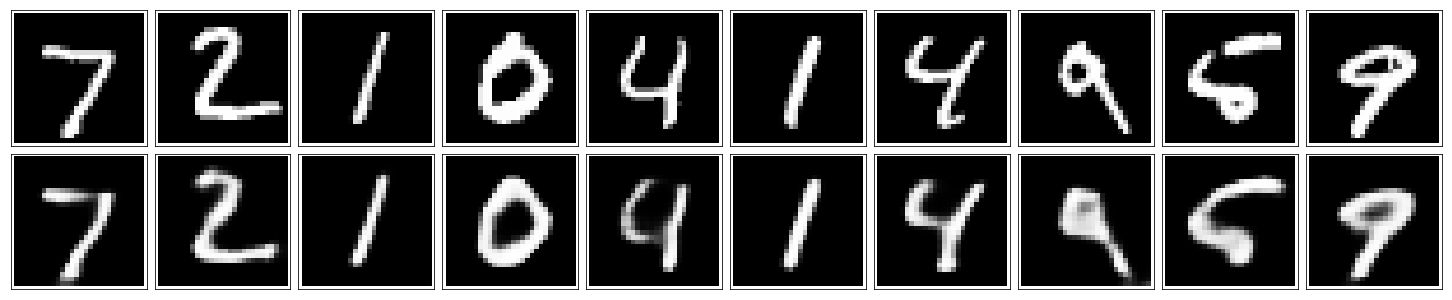

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [11]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [12]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding = "same")
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 16, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding = "same")
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 16, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding = "same")
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 16, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14, 14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 16, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28, 28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 32, (3, 3), padding = "same", activation = tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3, 3), padding = "same", activation = None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name = "decoded")

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = targets_, logits = logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [13]:
sess = tf.Session()

In [14]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.7098
Epoch: 1/100... Training loss: 0.6969
Epoch: 1/100... Training loss: 0.6905
Epoch: 1/100... Training loss: 0.6864
Epoch: 1/100... Training loss: 0.6801
Epoch: 1/100... Training loss: 0.6720
Epoch: 1/100... Training loss: 0.6604
Epoch: 1/100... Training loss: 0.6451
Epoch: 1/100... Training loss: 0.6273
Epoch: 1/100... Training loss: 0.6046
Epoch: 1/100... Training loss: 0.5759
Epoch: 1/100... Training loss: 0.5460
Epoch: 1/100... Training loss: 0.5217
Epoch: 1/100... Training loss: 0.5048
Epoch: 1/100... Training loss: 0.5082
Epoch: 1/100... Training loss: 0.5275
Epoch: 1/100... Training loss: 0.5308
Epoch: 1/100... Training loss: 0.5254
Epoch: 1/100... Training loss: 0.5048
Epoch: 1/100... Training loss: 0.4824
Epoch: 1/100... Training loss: 0.4763
Epoch: 1/100... Training loss: 0.4755
Epoch: 1/100... Training loss: 0.4815
Epoch: 1/100... Training loss: 0.4791
Epoch: 1/100... Training loss: 0.4741
Epoch: 1/100... Training loss: 0.4677
Epoch: 1/100

Epoch: 1/100... Training loss: 0.1883
Epoch: 1/100... Training loss: 0.1866
Epoch: 1/100... Training loss: 0.1958
Epoch: 1/100... Training loss: 0.1917
Epoch: 1/100... Training loss: 0.1958
Epoch: 1/100... Training loss: 0.1837
Epoch: 1/100... Training loss: 0.1941
Epoch: 1/100... Training loss: 0.1872
Epoch: 1/100... Training loss: 0.1893
Epoch: 1/100... Training loss: 0.1855
Epoch: 1/100... Training loss: 0.1902
Epoch: 1/100... Training loss: 0.1895
Epoch: 1/100... Training loss: 0.1863
Epoch: 1/100... Training loss: 0.1839
Epoch: 1/100... Training loss: 0.1872
Epoch: 1/100... Training loss: 0.1863
Epoch: 1/100... Training loss: 0.1832
Epoch: 1/100... Training loss: 0.1865
Epoch: 1/100... Training loss: 0.1871
Epoch: 1/100... Training loss: 0.1850
Epoch: 1/100... Training loss: 0.1774
Epoch: 1/100... Training loss: 0.1861
Epoch: 1/100... Training loss: 0.1834
Epoch: 1/100... Training loss: 0.1872
Epoch: 1/100... Training loss: 0.1809
Epoch: 1/100... Training loss: 0.1867
Epoch: 1/100

KeyboardInterrupt: 

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

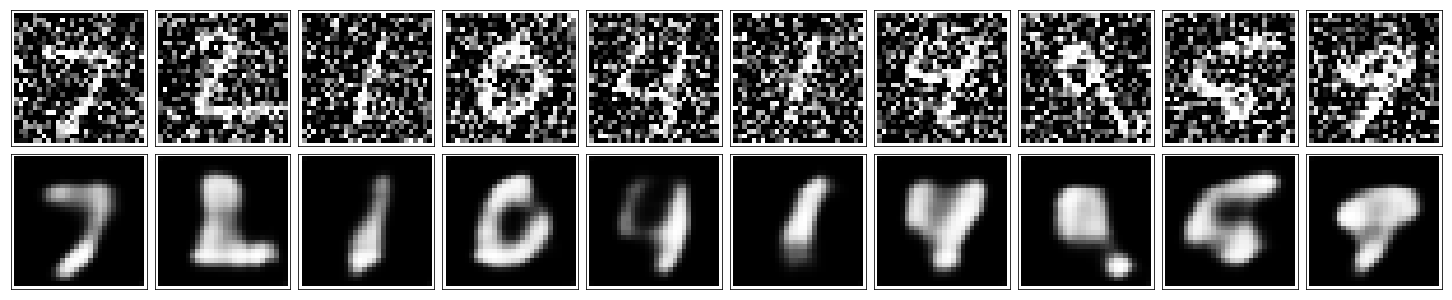

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)